# RCT Lean Modeling

## Introduction

This notebook implements the **RCT Lean modeling approach** for predicting control arm outcomes in randomized controlled trials (RCTs) using a **Leave-One-Out (LOO) protocol**. The primary goal is to develop and evaluate baseline approaches for predicting control arm performance when designing new clinical trials.

### Key Methodology:
- **Training Data**: Uses control arm data from existing RCTs to train predictive models
- **Target**: Predicts control arm outcomes (PFS median months) for held-out trials
- **Evaluation**: Calculates Average Treatment Effect (ATE) using intervention arm data
- **Validation Protocol**: Leave-one-out cross-validation where each trial is predicted using all other trials

This notebook compares multiple baseline approaches to establish benchmarks for more sophisticated modeling techniques.

## Import Required Libraries

Loading essential libraries for:
- **Data manipulation**: pandas, numpy
- **Statistical modeling**: statsmodels, scipy
- **Machine learning**: sklearn, lightgbm
- **Visualization**: plotly
- **Configuration management**: json

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import plotly.express as px
from scipy import stats
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import linear_model
import json
import os
%load_ext autoreload

## Load Feature Configuration from JSON

### Configuration-Driven Feature Selection

This approach uses a JSON configuration file to define:
- **Target variable**: The outcome we want to predict (PFS_median_months)
- **Feature groups**: Organized sets of related features (demographics, biomarkers, treatments, etc.)
- **Column mappings**: Flexible naming for trial ID, control arm indicators, etc.
- **Interaction terms**: Pre-defined engineered features, feature combinations

**Benefits of configuration-driven approach:**
- Easy experimentation with different feature sets
- Reproducible feature selection
- Clear documentation of modeling choices
- Flexible adaptation to different datasets

In [2]:
# Load feature configuration from JSON
config_path = os.path.join('config', 'feature_config.json')

with open(config_path, 'r') as f:
    feature_config = json.load(f)

# Extract target variable name
target_col = feature_config.get('target', 'PFS_median_months')

# Determine which feature groups to use
feature_groups_to_use = feature_config.get('feature_groups_to_use', list(feature_config['features'].keys()))

# Combine selected feature groups into one list
ftr = []
for group in feature_groups_to_use:
    ftr.extend(feature_config['features'].get(group, []))

print(f"Target variable: {target_col}")
print(f"Number of features: {len(ftr)}")
print("Feature groups included:")
for group in feature_groups_to_use:
    print(f"  - {group}: {len(feature_config['features'].get(group, []))} features")

Target variable: PFS_median_months
Number of features: 30
Feature groups included:
  - patient_demographics: 5 features
  - disease_characteristics: 6 features
  - drug_class: 12 features
  - treatment_features: 7 features


## Display Selected Features

### Feature Categories Overview

Showing the organized feature groups that will be used in modeling:
- **Demographics**: Age, gender, smoking status
- **Clinical characteristics**: ECOG status, disease stage, brain metastases
- **Biomarkers**: EGFR mutation status and other molecular markers
- **Treatment features**: Drug classes, combination therapies, complexity scores
- **Trial design features**: Population size, control arm types

This transparency helps understand what information the models use for predictions.

### Note -- Dont need to define your own feature groups here

In [3]:
# Display the selected features
for group in feature_groups_to_use:
    features = feature_config['features'].get(group, [])
    print(f"\n{group.replace('_', ' ').title()}:")
    for f in features:
        print(f"  - {f}")


Patient Demographics:
  - gender_male_percent
  - age_median
  - no_smoker_percent
  - ecog_1
  - smoker_percent

Disease Characteristics:
  - brain_metastase_yes
  - disease_stage_recurrent
  - disease_stage_III
  - disease_stage_IV
  - EGFR_wild
  - EGFR_positive_mutation

Drug Class:
  - EGFR_TKI
  - Platinum_Chemotherapy
  - Anti_VEGF
  - PD1_PDL1_Inhibitor
  - Antimetabolite
  - Taxane
  - Antibody
  - Placebo_Supportive-Care
  - Chemotherapy
  - Targeted_Therapy
  - Immunotherapy
  - Anti-angiogenic_Other

Treatment Features:
  - combo_therapy
  - treatment_complexity
  - RCT_with_control_inter
  - is_arm_control
  - Population
  - First-in-Class
  - Next-Generation


In [4]:
# Extract column names from config
trial_id_col = feature_config.get('trial_id_column', 'NCT_ID')
control_arm_col = feature_config.get('control_arm_column', 'is_arm_control')
intervention_outcome_col = feature_config.get('intervention_outcome_column', 'intervention_outcome')

print(f"Trial ID column: {trial_id_col}")
print(f"Control arm column: {control_arm_col}")
print(f"Intervention outcome column: {intervention_outcome_col}")

Trial ID column: NCT_ID
Control arm column: is_arm_control
Intervention outcome column: intervention_outcome


# Interaction terms which would be used in Lasso

In [5]:
interaction_terms = feature_config.get('interaction_terms', [])
interaction_terms

[{'name': 'int_outcome_x_egfr',
  'feature1': 'intervention_outcome',
  'feature2': 'EGFR_TKI'},
 {'name': 'int_outcome_x_immuno',
  'feature1': 'intervention_outcome',
  'feature2': 'PD1_PDL1_Inhibitor'}]

In [6]:
similarity_features = feature_config.get('similarity_features', {}).get('drug_class', [])
print(f"Similarity features: {similarity_features}")

Similarity features: ['EGFR_TKI', 'Platinum_Chemotherapy', 'Anti_VEGF', 'PD1_PDL1_Inhibitor', 'Antimetabolite', 'Taxane', 'Antibody', 'Placebo_Supportive-Care']


# Data from previous notebook


In [7]:
training_df = pd.read_csv("processed_training_data.csv")
training_df.head()

,NCT_ID,Arm,Population,intervention,RCT_with_control_inter,gender_male_percent,age_median,no_smoker_percent,ecog_1,brain_metastase_yes,...,is_arm_control,combo_therapy,egfr_targeted,egfr_tki_use,high_risk_profile,novelty_score,elderly_male,large_trial,treatment_complexity,smoker_percent
0,NCT01364012,Intervention,138.0,bevacizumab + platinum doublet chemo (carbopla...,1.0,54.0,57.0,50.0,75.0,0.0,...,0,1,0.0,0.0,1,1.0,0,0,3.0,50.0
1,NCT01364012,Control,138.0,placebo + platinum doublet chemo (carboplatin ...,1.0,56.0,56.0,50.0,80.0,0.0,...,1,0,0.0,0.0,1,0.0,0,0,1.0,50.0
2,NCT01469000,Intervention,126.0,pemetrexed + gefitinib,1.0,35.0,62.0,64.0,69.0,0.0,...,0,1,100.0,100.0,1,1.0,0,0,2.0,36.0
3,NCT01469000,Control,65.0,gefitinib,1.0,37.0,62.0,72.0,68.0,0.0,...,1,0,100.0,100.0,1,1.0,0,0,1.0,28.0
4,NCT02099058,Intervention,28.0,telisotuzumab vedotin + erlotinib,0.0,32.0,60.0,0.0,71.0,0.0,...,0,0,100.0,100.0,1,1.0,0,0,2.0,100.0


In [8]:
import ast
# Function to safely convert string to list
def safe_literal_eval(val):
    if pd.isna(val):
        return np.nan
    return ast.literal_eval(val)

# Apply conversion
training_df['PFS_median_CI'] = training_df['PFS_median_CI'].apply(safe_literal_eval)


In [9]:
# how many RCTS we've got
num_trials = training_df[trial_id_col].nunique()
print(f"Number of RCTs in the training data: {num_trials}")

# count of arms
training_df.shape[0]

Number of RCTs in the training data: 27


57

In [10]:
list_ftr_selected = ftr.copy()

In [11]:
# Import utility functions
from utilities.utils import *

# ATE Validation Approaches

## Methodology Overview

We implement multiple baseline approaches to predict control arm outcomes and calculate Average Treatment Effects (ATE). Each approach uses a **Leave-One-Out protocol**:

### Leave-One-Out Protocol Steps:
1. **Select target trial**: Choose one RCT to predict (hold-out)
2. **Training set creation**: Use all other RCTs' control arms for training
3. **Prediction**: Predict the held-out trial's control arm outcome
4. **ATE calculation**: Compare predicted control vs. actual intervention outcome
5. **Evaluation**: Compare predicted ATE with actual ATE

### Performance Metrics:
- **ATE direction accuracy**: Percentage of trials where predicted ATE has correct sign
- **R² score**: Correlation between predicted and actual ATEs
- **Spearman correlation**: Rank-order correlation for ATE predictions
- **RMSE**: Root mean squared error for both ATE and control arm predictions

![Results](../images//rct_lean_results_demo.png)

The baseline approach assumes that outcome from intervention arm is always better than control arm. Best baseline approach is 0.7 * treatment_arm_outcome(i.e PFS of intervention arm)

Overall, RF performs marginally better than baseline approach

*Figure: Results with ML approaches vs baseline approaches*

# Approach 1: Simple Average Method

## Methodology

**Prediction Strategy**: Use the simple average of all other control arms to predict the target control arm outcome.

### Algorithm Steps:
1. **Target identification**: For each control arm in the dataset
2. **Training set**: Remove the target trial entirely (both arms)
3. **Prediction**: Calculate mean PFS of all remaining control arms
4. **ATE calculation**: Subtract predicted control from actual intervention outcome


In [12]:
results_average = []
for index, row in training_df.iterrows():
    rct_name = row[trial_id_col]
    is_arm_control = row[control_arm_col]
    
    if is_arm_control == 1:
        # ground truth
        outcome_control = round(row[target_col],2)

        # dropping the row we try to predict
        df_training_i = training_df.drop(index)

        # Get the trt outcome of the RCT targeted
        trt_arm = training_df.loc[training_df[trial_id_col] == rct_name, :]
        trt_outcome = trt_arm.loc[trt_arm[control_arm_col] != 1, target_col]
        trt_outcome = round(trt_outcome.mean(),2)

        # User other RCTs to calculate the AVG
        # only control arms
        control_df = df_training_i.loc[df_training_i[control_arm_col] == 1, :]
        # from other RCTs
        predicted_outcome = round(control_df.loc[control_df[trial_id_col] != rct_name, target_col].mean(),2)
    
        real_ate = round(trt_outcome - outcome_control, 2)
        pred_ate = round(trt_outcome - predicted_outcome, 2)
        results_average.append({
            "real_ate": real_ate,
            "pred_ate": pred_ate,
            "outcome_control": outcome_control,
            "predicted_outcome": predicted_outcome,
            "rct_name": rct_name,
            "intervention": row["intervention"],
            "Arm": row["Arm"],
        })
        print(f"{rct_name} - arm: {row['Arm']} - intervention: {trt_outcome} -real_outcome: {outcome_control}, pred_outcome: {predicted_outcome}, real ATE: {real_ate} vs pred ATE: {pred_ate}")


NCT01364012 - arm: Control - intervention: 9.2 -real_outcome: 6.5, pred_outcome: 6.22, real ATE: 2.7 vs pred ATE: 2.98
NCT01469000 - arm: Control - intervention: 15.8 -real_outcome: 10.9, pred_outcome: 6.04, real ATE: 4.9 vs pred ATE: 9.76
NCT03515837 - arm: Control - intervention: 5.6 -real_outcome: 5.5, pred_outcome: 6.26, real ATE: 0.1 vs pred ATE: -0.66
NCT04129502 - arm: Control - intervention: 9.6 -real_outcome: 9.6, pred_outcome: 6.09, real ATE: 0.0 vs pred ATE: 3.51
NCT04194203 - arm: Control - intervention: 9.5 -real_outcome: 7.1, pred_outcome: 6.16, real ATE: 2.4 vs pred ATE: 3.34
NCT04538664 - arm: Control - intervention: 11.4 -real_outcome: 6.7, pred_outcome: 6.21, real ATE: 4.7 vs pred ATE: 5.19
NCT04988295 - arm: Control - intervention: 7.3 -real_outcome: 4.2, pred_outcome: 6.32, real ATE: 3.1 vs pred ATE: 0.98
NCT02142738 - arm: Control - intervention: 7.7 -real_outcome: 5.5, pred_outcome: 6.26, real ATE: 2.2 vs pred ATE: 1.44
NCT02041533 - arm: Control - intervention: 4

# Approach 2: Similarity-Based Method

## Methodology

**Prediction Strategy**: Use outcomes from the most similar trials based on drug class features to predict control arm performance.

### Algorithm Steps:
1. **Similarity calculation**: Compute Jaccard similarity for drug class features between target trial and all other trials
2. **Ranking**: Sort other trials by similarity score (highest first)
3. **Selection**: Use top 10 most similar trials for prediction
4. **Prediction**: Calculate weighted average of similar trials' control arm outcomes
5. **Fallback**: If no similar trials found, use global average

### Similarity Metrics:
- **Jaccard Index**: |intersection| / |union| of drug class features
- **Drug classes considered**: EGFR_TKI, PD1_PDL1_Inhibitor, Anti_VEGF, etc.
- **Special handling**: Trials with no drug features get similarity score of 0.5



In [13]:
def get_enhanced_similarity_features(training_df, target_trial_idx, target_col="PFS_median_months"):
    """
    For a given control arm, calculate:
    1. Top 5 similar trials' mean PFS (based on drug class similarity)
    2. Average PFS of all other control arms
    """
    # Features to use for similarity calculation (drug classes)
    
    drug_class_features = feature_config.get('similarity_features', {}).get('drug_class', [])
    
    # Get target trial data
    target_trial = training_df.loc[target_trial_idx]
    target_nct = target_trial[trial_id_col]
    
    # Get all control arms from other trials
    other_controls = training_df[(training_df[control_arm_col] == 1) & 
                                (training_df[trial_id_col] != target_nct)].copy()
    
    # 1. Calculate the average PFS of all other control arms
    all_other_controls_avg_pfs = other_controls[target_col].mean()
    
    # 2. Calculate Jaccard similarity for the top similar trials
    similarities = []
    for idx, control in other_controls.iterrows():
        # Calculate Jaccard similarity for drug class features
        target_features = set([feat for feat in drug_class_features if target_trial[feat] == 1])
        control_features = set([feat for feat in drug_class_features if control[feat] == 1])
        
        if len(target_features.union(control_features)) == 0:
            # If both have no drug features, they're somewhat similar (placebo-like)
            jaccard = 0.5
        else:
            jaccard = len(target_features.intersection(control_features)) / len(target_features.union(control_features))
        
        similarities.append((idx, jaccard, control[target_col]))
    
    # Sort by similarity (highest first)
    similarities.sort(key=lambda x: x[1], reverse=True)
    
    # Get top 5 most similar trials
    top_similar = similarities[:10]
    
    
    # Calculate mean PFS from similar trials
    if not top_similar:
        similar_trials_mean_pfs = np.nan
    else:
        similar_pfs_values = [s[2] for s in top_similar if s[1]]
        similar_trials_mean_pfs = np.mean(similar_pfs_values)
    
    return {
        'similar_trials_mean_pfs': round(similar_trials_mean_pfs,2),
        'all_other_controls_avg_pfs': round(all_other_controls_avg_pfs,2)
    }

In [14]:
results_similarity = []
for index, row in training_df.iterrows():
    rct_name = row[trial_id_col]
    is_arm_control = row[control_arm_col]
    
    if is_arm_control == 1:
        # Ground truth
        outcome_control = round(row[target_col], 2)
        
        # Get the treatment outcome of the RCT targeted
        trt_arm = training_df.loc[training_df[trial_id_col] == rct_name, :]
        trt_outcome = trt_arm.loc[trt_arm[control_arm_col] != 1, target_col]
        
        if trt_outcome.empty or pd.isna(trt_outcome.mean()):
            continue
            
        trt_outcome = round(trt_outcome.mean(), 2)
        
        # Get similar trials' mean PFS using existing function
        similarity_features = get_enhanced_similarity_features(training_df, index, target_col)
        
        # Use the similar trials' mean PFS as the predicted outcome
        predicted_outcome = similarity_features['similar_trials_mean_pfs']
        
        # If no similar trials found, fall back to average of all control arms
        if pd.isna(predicted_outcome):
            predicted_outcome = similarity_features['all_other_controls_avg_pfs']
            prediction_method = "all_controls_average"
        else:
            prediction_method = "similar_trials_average"
        
        # Calculate ATEs
        real_ate = round(trt_outcome - outcome_control, 2)
        pred_ate = round(trt_outcome - predicted_outcome, 2)
        
        # Cap extreme ATE predictions
        pred_ate = min(max(pred_ate, -4), 4)
        
        # Store results
        results_similarity.append({
            "real_ate": real_ate,
            "pred_ate": pred_ate,
            "outcome_control": outcome_control,
            "predicted_outcome": predicted_outcome,
            "rct_name": rct_name,
            "intervention": row["intervention"],
            "Arm": row["Arm"],
            "prediction_method": prediction_method
        })
        
        print(f"{rct_name} - arm: {row['Arm']} - intervention: {trt_outcome} - real_outcome: {outcome_control}, pred_outcome: {predicted_outcome}, real ATE: {real_ate} vs pred ATE: {pred_ate}")




NCT01364012 - arm: Control - intervention: 9.2 - real_outcome: 6.5, pred_outcome: 5.45, real ATE: 2.7 vs pred ATE: 3.75
NCT01469000 - arm: Control - intervention: 15.8 - real_outcome: 10.9, pred_outcome: 6.04, real ATE: 4.9 vs pred ATE: 4
NCT03515837 - arm: Control - intervention: 5.6 - real_outcome: 5.5, pred_outcome: 6.16, real ATE: 0.1 vs pred ATE: -0.56
NCT04129502 - arm: Control - intervention: 9.6 - real_outcome: 9.6, pred_outcome: 6.15, real ATE: 0.0 vs pred ATE: 3.45
NCT04194203 - arm: Control - intervention: 9.5 - real_outcome: 7.1, pred_outcome: 6.5, real ATE: 2.4 vs pred ATE: 3.0
NCT04538664 - arm: Control - intervention: 11.4 - real_outcome: 6.7, pred_outcome: 6.1, real ATE: 4.7 vs pred ATE: 4
NCT04988295 - arm: Control - intervention: 7.3 - real_outcome: 4.2, pred_outcome: 6.29, real ATE: 3.1 vs pred ATE: 1.01
NCT02142738 - arm: Control - intervention: 7.7 - real_outcome: 5.5, pred_outcome: 5.74, real ATE: 2.2 vs pred ATE: 1.96
NCT02041533 - arm: Control - intervention: 4.

/Users/Sayan_Chakraborty/Desktop/QuantumBlack/Eureka/rct_lean_blx/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/Sayan_Chakraborty/Desktop/QuantumBlack/Eureka/rct_lean_blx/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# Approach 3: Conditional Machine Learning (Lasso)

## Methodology

**Prediction Strategy**: Use machine learning with intervention outcome as a conditional feature to predict control arm outcomes.

### Novel Features:
1. **Intervention outcome conditioning**: Add the intervention arm outcome as a feature
2. **Interaction terms**: Create interactions between intervention outcome and drug classes
3. **Trial indicators**: Flag the target trial and prediction row

### Algorithm Steps:
1. **Feature engineering**: Add intervention_outcome, interaction terms, and trial flags
2. **Training preparation**: Use only control arms, exclude target trial
3. **Model training**: Fit Lasso regression with alpha=0.4
4. **Prediction**: Predict using target trial features + its intervention outcome





In [15]:

results_ml = []
for index, row in training_df.iterrows():
    rct_name = row[trial_id_col]
    is_arm_control = row[control_arm_col]
    
    if is_arm_control == 1:
        # ground truth
        outcome_control = round(row[target_col], 2)
        
        # Get the trt outcome of the RCT targeted
        trt_arm = training_df.loc[training_df[trial_id_col] == rct_name, :]
        trt_outcome = trt_arm.loc[trt_arm[control_arm_col] != 1, target_col]
        trt_outcome = round(trt_outcome.mean(), 2)
        
        # User ML predictions
        training_j = training_df.copy()
        # flag inference row
        training_j["is_to_predict"] = np.where(training_j.index == index, 1, 0)
        # flag RCT row
        training_j["is_targeted_rct"] = np.where(training_j[trial_id_col] == rct_name, 1, 0)

        # Add intervention outcome as a feature for all control arms
        # For each control arm, add the intervention outcome from the same trial
        for idx, control_row in training_j[training_j[control_arm_col] == 1].iterrows():
            ctrl_rct = control_row[trial_id_col]
            # Get intervention outcome for this control's trial
            ctrl_trt_outcome = training_j.loc[(training_j[trial_id_col] == ctrl_rct) & 
                                             (training_j[control_arm_col] != 1), target_col]
            
            if not ctrl_trt_outcome.empty and not pd.isna(ctrl_trt_outcome.mean()):
                training_j.loc[idx, intervention_outcome_col] = round(ctrl_trt_outcome.mean(), 2)
            else:
                training_j.loc[idx, intervention_outcome_col] = np.nan
        
        training_j = training_j.dropna(subset=[intervention_outcome_col])
        # Create interaction terms
        '''
        training_j["int_outcome_x_egfr"] = training_j[intervention_outcome_col] * training_j["EGFR_TKI"]
        training_j["int_outcome_x_immuno"] = training_j[intervention_outcome_col] * training_j["PD1_PDL1_Inhibitor"]
        '''
        for f in interaction_terms:
            if f['feature1'] in training_j.columns and f['feature2'] in training_j.columns:
                training_j[f['name']] = training_j[f['feature1']] * training_j[f['feature2']]
        
        # only consider control arms for training
        training_j = training_j.loc[training_j[control_arm_col] == 1, :]
        training_j = prepare_data(training_j, list_ftr_selected + ["is_to_predict", "is_targeted_rct", intervention_outcome_col, "int_outcome_x_egfr", "int_outcome_x_immuno", target_col])
        training_j = run_fillna(training_j)

        # Make sure the target row has the intervention outcome
        training_j.loc[training_j["is_to_predict"] == 1, intervention_outcome_col] = trt_outcome
        
        inference_df = training_j.loc[training_j["is_to_predict"] == 1, :]
        if inference_df.empty:
            print(f"Skipping {rct_name} as no inference data available.")
            continue
        training_j = training_j.loc[training_j["is_to_predict"] != 1, :]
        training_j = training_j.loc[training_j["is_targeted_rct"] != 1, :]

        # Fit and summarize OLS model
        lasso_model = linear_model.Lasso(alpha=0.4)
        lasso_model.fit(training_j[list_ftr_selected + [intervention_outcome_col]], training_j[target_col])
        predicted_outcome = round(lasso_model.predict(inference_df[list_ftr_selected + [intervention_outcome_col]])[0], 2)
    
        real_ate = round(trt_outcome - outcome_control, 2)
        pred_ate = round(trt_outcome - predicted_outcome, 2)
        results_ml.append({
            "real_ate": real_ate,
            "pred_ate": pred_ate,
            "outcome_control": outcome_control,
            "predicted_outcome": predicted_outcome,
            "rct_name": rct_name,
            "intervention": row["intervention"],
            "Arm": row["Arm"],
        })
            
        print(f"{rct_name} - arm: {row['Arm']} - intervention: {trt_outcome} - real_outcome: {outcome_control}, pred_outcome: {predicted_outcome}, real ATE: {real_ate} vs pred ATE: {pred_ate}")

NCT01364012 - arm: Control - intervention: 9.2 - real_outcome: 6.5, pred_outcome: 7.58, real ATE: 2.7 vs pred ATE: 1.62
NCT01469000 - arm: Control - intervention: 15.8 - real_outcome: 10.9, pred_outcome: 10.49, real ATE: 4.9 vs pred ATE: 5.31
NCT03515837 - arm: Control - intervention: 5.6 - real_outcome: 5.5, pred_outcome: 6.04, real ATE: 0.1 vs pred ATE: -0.44
NCT04129502 - arm: Control - intervention: 9.6 - real_outcome: 9.6, pred_outcome: 6.0, real ATE: 0.0 vs pred ATE: 3.6
NCT04194203 - arm: Control - intervention: 9.5 - real_outcome: 7.1, pred_outcome: 5.65, real ATE: 2.4 vs pred ATE: 3.85
NCT04538664 - arm: Control - intervention: 11.4 - real_outcome: 6.7, pred_outcome: 7.74, real ATE: 4.7 vs pred ATE: 3.66
NCT04988295 - arm: Control - intervention: 7.3 - real_outcome: 4.2, pred_outcome: 6.93, real ATE: 3.1 vs pred ATE: 0.37
NCT02142738 - arm: Control - intervention: 7.7 - real_outcome: 5.5, pred_outcome: 5.19, real ATE: 2.2 vs pred ATE: 2.51
NCT02041533 - arm: Control - interven

## Approach 3: Conditional Machine Learning (ElasticNet)

**Extension of the conditional ML approach using ElasticNet regularization:**

### Key Differences from Lasso:
- **Regularization**: Combines L1 (Lasso) and L2 (Ridge) penalties
- **Feature selection**: More stable feature selection with correlated features
- **Hyperparameters**: alpha=0.4, automatic L1/L2 ratio selection

### Interaction Terms:
- **Configurable**: Uses interaction terms defined in the configuration file
- **Drug-specific**: Creates interactions between intervention outcome and specific drug classes

**Expected Benefits**: Better handling of multicollinearity, more robust predictions

In [16]:
results_elastic_net = []
for index, row in training_df.iterrows():
    rct_name = row[trial_id_col]
    is_arm_control = row[control_arm_col]
    
    if is_arm_control == 1:
        # ground truth
        outcome_control = round(row[target_col], 2)
        
        # Get the trt outcome of the RCT targeted
        trt_arm = training_df.loc[training_df[trial_id_col] == rct_name, :]
        trt_outcome = trt_arm.loc[trt_arm[control_arm_col] != 1, target_col]
        trt_outcome = round(trt_outcome.mean(), 2)
        
        # User ML predictions
        training_j = training_df.copy()
        # flag inference row
        training_j["is_to_predict"] = np.where(training_j.index == index, 1, 0)
        # flag RCT row
        training_j["is_targeted_rct"] = np.where(training_j[trial_id_col] == rct_name, 1, 0)

        # Add intervention outcome as a feature for all control arms
        # For each control arm, add the intervention outcome from the same trial
        for idx, control_row in training_j[training_j[control_arm_col] == 1].iterrows():
            ctrl_rct = control_row[trial_id_col]
            # Get intervention outcome for this control's trial
            ctrl_trt_outcome = training_j.loc[(training_j[trial_id_col] == ctrl_rct) & 
                                             (training_j[control_arm_col] != 1), target_col]
            
            if not ctrl_trt_outcome.empty and not pd.isna(ctrl_trt_outcome.mean()):
                training_j.loc[idx, intervention_outcome_col] = round(ctrl_trt_outcome.mean(), 2)
            else:
                training_j.loc[idx, intervention_outcome_col] = np.nan

            
        
        training_j = training_j.dropna(subset=[intervention_outcome_col])
        
        # Create interaction terms
        '''
        training_j["int_outcome_x_egfr"] = training_j[intervention_outcome_col] * training_j["EGFR_TKI"]
        training_j["int_outcome_x_immuno"] = training_j[intervention_outcome_col] * training_j["PD1_PDL1_Inhibitor"]
        '''
        for f in interaction_terms:
            if f['feature1'] in training_j.columns and f['feature2'] in training_j.columns:
                training_j[f['name']] = training_j[f['feature1']] * training_j[f['feature2']]
        
        # only consider control arms for training
        training_j = training_j.loc[training_j[control_arm_col] == 1, :]
        training_j = prepare_data(training_j, list_ftr_selected + ["is_to_predict", "is_targeted_rct", intervention_outcome_col, "int_outcome_x_egfr", "int_outcome_x_immuno", target_col])
        training_j = run_fillna(training_j)

        # Make sure the target row has the intervention outcome
        training_j.loc[training_j["is_to_predict"] == 1, intervention_outcome_col] = trt_outcome
        
        inference_df = training_j.loc[training_j["is_to_predict"] == 1, :]
        if inference_df.empty:
            print(f"Skipping {rct_name} as no inference data available.")
            continue
        training_j = training_j.loc[training_j["is_to_predict"] != 1, :]
        training_j = training_j.loc[training_j["is_targeted_rct"] != 1, :]

        # Fit and summarize ElasticNet model
        lasso_model = linear_model.ElasticNet(alpha=0.4, random_state=42)
        lasso_model.fit(training_j[list_ftr_selected + [intervention_outcome_col]], training_j[target_col])
        predicted_outcome = round(lasso_model.predict(inference_df[list_ftr_selected + [intervention_outcome_col]])[0], 2)
    
        real_ate = round(trt_outcome - outcome_control, 2)
        pred_ate = round(trt_outcome - predicted_outcome, 2)
        
        results_elastic_net.append({
            "real_ate": real_ate,
            "pred_ate": pred_ate,
            "outcome_control": outcome_control,
            "predicted_outcome": predicted_outcome,
            "rct_name": rct_name,
            "intervention": row["intervention"],
            "Arm": row["Arm"],
        })
            
        print(f"{rct_name} - arm: {row['Arm']} - intervention: {trt_outcome} - real_outcome: {outcome_control}, pred_outcome: {predicted_outcome}, real ATE: {real_ate} vs pred ATE: {pred_ate}")

NCT01364012 - arm: Control - intervention: 9.2 - real_outcome: 6.5, pred_outcome: 7.66, real ATE: 2.7 vs pred ATE: 1.54
NCT01469000 - arm: Control - intervention: 15.8 - real_outcome: 10.9, pred_outcome: 11.25, real ATE: 4.9 vs pred ATE: 4.55
NCT03515837 - arm: Control - intervention: 5.6 - real_outcome: 5.5, pred_outcome: 5.93, real ATE: 0.1 vs pred ATE: -0.33
NCT04129502 - arm: Control - intervention: 9.6 - real_outcome: 9.6, pred_outcome: 6.0, real ATE: 0.0 vs pred ATE: 3.6
NCT04194203 - arm: Control - intervention: 9.5 - real_outcome: 7.1, pred_outcome: 5.45, real ATE: 2.4 vs pred ATE: 4.05
NCT04538664 - arm: Control - intervention: 11.4 - real_outcome: 6.7, pred_outcome: 7.71, real ATE: 4.7 vs pred ATE: 3.69
NCT04988295 - arm: Control - intervention: 7.3 - real_outcome: 4.2, pred_outcome: 7.0, real ATE: 3.1 vs pred ATE: 0.3
NCT02142738 - arm: Control - intervention: 7.7 - real_outcome: 5.5, pred_outcome: 5.04, real ATE: 2.2 vs pred ATE: 2.66
NCT02041533 - arm: Control - interventi

## Approach 3: Conditional Machine Learning (Random Forest)

**Tree-based ensemble approach for conditional modeling:**

### Model Configuration:
- **Ensemble size**: 100 trees
- **Max depth**: 10 (to prevent overfitting)
- **Min samples split**: 10 (conservative for small datasets)
- **Parallel processing**: n_jobs=-1 for faster training

### ATE Bounds Implementation:
- **Statistical bounds**: Calculate 10th-90th percentile of ATEs from other trials
- **Clipping**: Constrain predicted ATEs to reasonable ranges
- **Rationale**: Prevents extreme predictions that are clinically implausible


In [17]:
def get_ate_bounds_from_other_trials(training_df, target_col, current_rct_name, percentile_low=10, percentile_high=90):
    """
    Calculate ATE bounds based only on the distribution of ATEs from other trials
    (excluding the trial we're trying to predict)
    """
    ates = []
    
    # Only consider RCTs that are not the current one
    other_rcts = training_df[training_df['NCT_ID'] != current_rct_name]['NCT_ID'].unique()
    
    # For each other RCT, calculate its ATE
    for rct_name in other_rcts:
        rct_data = training_df[training_df['NCT_ID'] == rct_name]
        
        # Get control outcome
        control_outcomes = rct_data.loc[rct_data['is_arm_control'] == 1, target_col]
        # Get treatment outcomes
        treatment_outcomes = rct_data.loc[rct_data['is_arm_control'] != 1, target_col]
        
        if not control_outcomes.empty and not treatment_outcomes.empty:
            control_outcome = control_outcomes.mean()
            treatment_outcome = treatment_outcomes.mean()
            
            # Calculate ATE
            ate = treatment_outcome - control_outcome
            ates.append(ate)
    
    # Calculate percentiles if we have enough data
    if len(ates) >= 5:
        lower_bound = np.percentile(ates, percentile_low)
        upper_bound = np.percentile(ates, percentile_high)
        return lower_bound, upper_bound
    else:
        # Fallback to reasonable defaults if not enough data
        return -4, 4

In [18]:
list_ftr_selected

['gender_male_percent',
 'age_median',
 'no_smoker_percent',
 'ecog_1',
 'smoker_percent',
 'brain_metastase_yes',
 'disease_stage_recurrent',
 'disease_stage_III',
 'disease_stage_IV',
 'EGFR_wild',
 'EGFR_positive_mutation',
 'EGFR_TKI',
 'Platinum_Chemotherapy',
 'Anti_VEGF',
 'PD1_PDL1_Inhibitor',
 'Antimetabolite',
 'Taxane',
 'Antibody',
 'Placebo_Supportive-Care',
 'Chemotherapy',
 'Targeted_Therapy',
 'Immunotherapy',
 'Anti-angiogenic_Other',
 'combo_therapy',
 'treatment_complexity',
 'RCT_with_control_inter',
 'is_arm_control',
 'Population',
 'First-in-Class',
 'Next-Generation']

In [19]:
from sklearn.ensemble import RandomForestRegressor

results_rf = []

for index, row in training_df.iterrows():
    rct_name = row[trial_id_col]
    is_arm_control = row[control_arm_col]
    
    if is_arm_control == 1:
        # ground truth
        outcome_control = round(row[target_col], 2)
        
        # Get the trt outcome of the RCT targeted
        trt_arm = training_df.loc[training_df[trial_id_col] == rct_name, :]
        trt_outcome = trt_arm.loc[trt_arm[control_arm_col] != 1, target_col]
        
        if trt_outcome.empty or pd.isna(trt_outcome.mean()):
            continue
            
        trt_outcome = round(trt_outcome.mean(), 2)
        
        # User ML predictions
        training_j = training_df.copy()
        # flag inference row
        training_j["is_to_predict"] = np.where(training_j.index == index, 1, 0)
        # flag RCT row
        training_j["is_targeted_rct"] = np.where(training_j[trial_id_col] == rct_name, 1, 0)

        # Add intervention outcome as a feature for all control arms
        # For each control arm, add the intervention outcome from the same trial
        for idx, control_row in training_j[training_j[control_arm_col] == 1].iterrows():
            ctrl_rct = control_row[trial_id_col]
            # Get intervention outcome for this control's trial
            ctrl_trt_outcome = training_j.loc[(training_j[trial_id_col] == ctrl_rct) & 
                                             (training_j[control_arm_col] != 1), target_col]
            
            if not ctrl_trt_outcome.empty and not pd.isna(ctrl_trt_outcome.mean()):
                training_j.loc[idx, intervention_outcome_col] = round(ctrl_trt_outcome.mean(), 2)
            else:
                training_j.loc[idx, intervention_outcome_col] = np.nan
        
        training_j = training_j.dropna(subset=[intervention_outcome_col])
        
        # only consider control arms for training
        training_j = training_j.loc[training_j[control_arm_col] == 1, :]
        training_j = prepare_data(training_j, list_ftr_selected + ["is_to_predict", "is_targeted_rct", intervention_outcome_col, target_col])
        training_j = run_fillna(training_j)

        # Make sure the target row has the intervention outcome
        training_j.loc[training_j["is_to_predict"] == 1, intervention_outcome_col] = trt_outcome
        
        inference_df = training_j.loc[training_j["is_to_predict"] == 1, :]
        if inference_df.empty:
            print(f"Skipping {rct_name} as no inference data available.")
            continue
            
        # Remove target trial from training
        training_subset = training_j.loc[training_j["is_to_predict"] != 1, :]
        training_subset = training_subset.loc[training_subset["is_targeted_rct"] != 1, :]
        
        if len(training_subset) < 5:
            print(f"Skipping {rct_name} - insufficient training data ({len(training_subset)} samples)")
            continue

        # Fit Random Forest model
        lasso_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10, min_samples_split=10, min_samples_leaf=5)
        lasso_model.fit(training_subset[list_ftr_selected + [intervention_outcome_col]], training_subset[target_col])
        
        # ==========================================
        # CALCULATE TRAINING ACCURACY METRICS
        # ==========================================
        
        # Get training predictions
        training_preds = lasso_model.predict(training_subset[list_ftr_selected + [intervention_outcome_col]])
        training_true = training_subset[target_col].values
        
        # Calculate training metrics
        training_rmse = round(np.sqrt(mean_squared_error(training_true, training_preds)), 3)
        training_r2 = round(r2_score(training_true, training_preds), 3)
        training_mae = round(np.mean(np.abs(training_true - training_preds)), 3)
        training_bias = round(np.mean(training_preds - training_true), 3)
        training_abs_bias = round(np.mean(np.abs(training_preds - training_true)), 3)
        
        # ==========================================
        # GET TEST PREDICTION
        # ==========================================
        
        predicted_outcome = round(lasso_model.predict(inference_df[list_ftr_selected + [intervention_outcome_col]])[0], 2)
        
        real_ate = round(trt_outcome - outcome_control, 2)
        pred_ate = round(trt_outcome - predicted_outcome, 2)
        
        # Calculate ATE bounds from other trials (NOT including the current trial)
        # ate_lower_bound, ate_upper_bound = get_ate_bounds_from_other_trials(
        #     training_df, target_col, rct_name, percentile_low=10, percentile_high=90
        # )
        
        # ==========================================
        # STORE RESULTS WITH TRAINING METRICS
        # ==========================================
        
        results_rf.append({
            # Original results
            "real_ate": real_ate,
            "pred_ate": pred_ate,
            "outcome_control": outcome_control,
            "predicted_outcome": predicted_outcome,
            "rct_name": rct_name,
            "intervention": row["intervention"],
            "Arm": row["Arm"],
            "n_training_samples": len(training_subset),
            
            # NEW: Training accuracy metrics
            "training_rmse": training_rmse,
            "training_r2": training_r2,
            "training_mae": training_mae,
            "training_bias": training_bias,
            "training_abs_bias": training_abs_bias,
        })
            
        print(f"{rct_name} - arm: {row['Arm']} - intervention: {trt_outcome}")
        print(f"  Training: RMSE={training_rmse}, R²={training_r2}, MAE={training_mae}, Bias={training_bias}")
        print(f"  Real outcome: {outcome_control}, Pred: {predicted_outcome}")
        print(f"  Real ATE: {real_ate} vs Pred ATE: {pred_ate}")

NCT01364012 - arm: Control - intervention: 9.2
  Training: RMSE=0.991, R²=0.686, MAE=0.739, Bias=-0.002
  Real outcome: 6.5, Pred: 6.3
  Real ATE: 2.7 vs Pred ATE: 2.9
NCT01469000 - arm: Control - intervention: 15.8
  Training: RMSE=0.791, R²=0.713, MAE=0.582, Bias=0.0
  Real outcome: 10.9, Pred: 7.59
  Real ATE: 4.9 vs Pred ATE: 8.21
NCT03515837 - arm: Control - intervention: 5.6
  Training: RMSE=1.0, R²=0.678, MAE=0.72, Bias=-0.017
  Real outcome: 5.5, Pred: 5.18
  Real ATE: 0.1 vs Pred ATE: 0.42
NCT04129502 - arm: Control - intervention: 9.6
  Training: RMSE=0.955, R²=0.655, MAE=0.627, Bias=-0.042
  Real outcome: 9.6, Pred: 7.6
  Real ATE: 0.0 vs Pred ATE: 2.0
NCT04194203 - arm: Control - intervention: 9.5
  Training: RMSE=1.02, R²=0.677, MAE=0.729, Bias=-0.032
  Real outcome: 7.1, Pred: 7.8
  Real ATE: 2.4 vs Pred ATE: 1.7
NCT04538664 - arm: Control - intervention: 11.4
  Training: RMSE=0.95, R²=0.711, MAE=0.664, Bias=-0.055
  Real outcome: 6.7, Pred: 7.95
  Real ATE: 4.7 vs Pred A

## Approach 3: Conditional Machine Learning (LightGBM)

**Gradient boosting approach optimized for small datasets:**

### Conservative Hyperparameters:
- **Learning rate**: 0.05 (slow learning to prevent overfitting)
- **Max depth**: 3 (shallow trees)
- **Num leaves**: 7 (< 2^max_depth to prevent overfitting)
- **Regularization**: L1=0.1, L2=0.1 regularization
- **Subsampling**: 80% data and features per tree

### Small Dataset Adaptations:
- **Fewer estimators**: 50 trees instead of default
- **Conservative leaf settings**: min_data_in_leaf=3, min_child_samples=5
- **Early stopping**: Implicit through limited estimators

### ATE Bounds:
Same statistical bounding approach as Random Forest to ensure clinical plausibility.


In [20]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

results_lgbm = []
for index, row in training_df.iterrows():
    rct_name = row[trial_id_col]
    is_arm_control = row[control_arm_col]
    
    if is_arm_control == 1:
        # ground truth
        outcome_control = round(row[target_col], 2)
        
        # Get the trt outcome of the RCT targeted
        trt_arm = training_df.loc[training_df[trial_id_col] == rct_name, :]
        trt_outcome = trt_arm.loc[trt_arm[control_arm_col] != 1, target_col]
        
        if trt_outcome.empty or pd.isna(trt_outcome.mean()):
            continue
            
        trt_outcome = round(trt_outcome.mean(), 2)
        
        # User ML predictions
        training_j = training_df.copy()
        # flag inference row
        training_j["is_to_predict"] = np.where(training_j.index == index, 1, 0)
        # flag RCT row
        training_j["is_targeted_rct"] = np.where(training_j[trial_id_col] == rct_name, 1, 0)

        # Add intervention outcome as a feature for all control arms
        for idx, control_row in training_j[training_j[control_arm_col] == 1].iterrows():
            ctrl_rct = control_row[trial_id_col]
            # Get intervention outcome for this control's trial
            ctrl_trt_outcome = training_j.loc[(training_j[trial_id_col] == ctrl_rct) & 
                                             (training_j[control_arm_col] != 1), target_col]
            
            if not ctrl_trt_outcome.empty and not pd.isna(ctrl_trt_outcome.mean()):
                training_j.loc[idx, intervention_outcome_col] = round(ctrl_trt_outcome.mean(), 2)
            else:
                training_j.loc[idx, intervention_outcome_col] = np.nan
        
        training_j = training_j.dropna(subset=[intervention_outcome_col])
        
        # only consider control arms for training
        training_j = training_j.loc[training_j[control_arm_col] == 1, :]
        training_j = prepare_data(training_j, list_ftr_selected + ["is_to_predict", "is_targeted_rct", intervention_outcome_col, target_col])
        training_j = run_fillna(training_j)

        # Make sure the target row has the intervention outcome
        training_j.loc[training_j["is_to_predict"] == 1, intervention_outcome_col] = trt_outcome
        
        inference_df = training_j.loc[training_j["is_to_predict"] == 1, :]
        if inference_df.empty:
            print(f"Skipping {rct_name} as no inference data available.")
            continue
        
        # Create training set by removing inference row and rows from same trial
        training_j = training_j.loc[training_j["is_to_predict"] != 1, :]
        training_j = training_j.loc[training_j["is_targeted_rct"] != 1, :]

        # Configure LightGBM with conservative parameters for small datasets
        lgbm_params = {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'n_estimators': 100,            # Fewer trees to prevent overfitting
            'learning_rate': 0.05,         # Small learning rate
            'max_depth': 7,                # Shallow trees
            'num_leaves': 7,               # Limit leaves (should be < 2^max_depth)
            'min_data_in_leaf': 3,         # Similar to min_samples_leaf
            'min_child_samples': 5,        # Similar to min_samples_split
            'subsample': 0.8,              # Use 80% of data for each tree
            'colsample_bytree': 0.8,       # Use 80% of features for each tree
            'reg_alpha': 0.1,              # L1 regularization
            'reg_lambda': 0.1,             # L2 regularization
            'random_state': 42,
            'verbose': -1                  # Suppress output
        }
        
        # Prepare feature matrix and target
        X_train = training_j[list_ftr_selected + [intervention_outcome_col]]
        y_train = training_j[target_col]
        
        # Train LightGBM model
        lgbm_model = lgb.LGBMRegressor(**lgbm_params)
        lgbm_model.fit(X_train, y_train)
        
        # Predict
        X_pred = inference_df[list_ftr_selected + [intervention_outcome_col]]
        predicted_outcome = round(lgbm_model.predict(X_pred)[0], 2)
    
        # Calculate ATEs
        real_ate = round(trt_outcome - outcome_control, 2)
        pred_ate = round(trt_outcome - predicted_outcome, 2)
        
        # Apply statistical bounds to predicted ATE
        # ate_lower_bound, ate_upper_bound = get_ate_bounds_from_other_trials(
        #     training_df, target_col, rct_name, percentile_low=10, percentile_high=90
        # )

        
        
        # Store results
        results_lgbm.append({
            "real_ate": real_ate,
            "pred_ate": pred_ate,
            "outcome_control": outcome_control,
            "predicted_outcome": predicted_outcome,
            "rct_name": rct_name,
            "intervention": row["intervention"],
            "Arm": row["Arm"],
            #"bounds": f"[{round(ate_lower_bound,2)}, {round(ate_upper_bound,2)}]"
        })
            
        print(f"{rct_name} - arm: {row['Arm']} - intervention: {trt_outcome} - real_outcome: {outcome_control}, pred_outcome: {predicted_outcome}, real ATE: {real_ate} vs pred ATE: {pred_ate}")



NCT01364012 - arm: Control - intervention: 9.2 - real_outcome: 6.5, pred_outcome: 6.38, real ATE: 2.7 vs pred ATE: 2.82
NCT01469000 - arm: Control - intervention: 15.8 - real_outcome: 10.9, pred_outcome: 7.68, real ATE: 4.9 vs pred ATE: 8.12
NCT03515837 - arm: Control - intervention: 5.6 - real_outcome: 5.5, pred_outcome: 4.54, real ATE: 0.1 vs pred ATE: 1.06
NCT04129502 - arm: Control - intervention: 9.6 - real_outcome: 9.6, pred_outcome: 7.98, real ATE: 0.0 vs pred ATE: 1.62
NCT04194203 - arm: Control - intervention: 9.5 - real_outcome: 7.1, pred_outcome: 7.32, real ATE: 2.4 vs pred ATE: 2.18
NCT04538664 - arm: Control - intervention: 11.4 - real_outcome: 6.7, pred_outcome: 7.14, real ATE: 4.7 vs pred ATE: 4.26
NCT04988295 - arm: Control - intervention: 7.3 - real_outcome: 4.2, pred_outcome: 5.27, real ATE: 3.1 vs pred ATE: 2.03
NCT02142738 - arm: Control - intervention: 7.7 - real_outcome: 5.5, pred_outcome: 5.62, real ATE: 2.2 vs pred ATE: 2.08
NCT02041533 - arm: Control - interven

## Approach 3: Conditional Machine Learning (Catboost)

In [21]:
#with CI of OUTCOME and ATE
from utilities.catboost_quantile_utils import CatBoostQuantilePredictor

results_catboost_quantile = []

for index, row in training_df.iterrows():
    rct_name = row[trial_id_col]
    is_arm_control = row[control_arm_col]
    
    if is_arm_control == 1:
        # Ground truth
        outcome_control = round(row[target_col], 2)
        
        # Get the treatment outcome of the RCT targeted
        trt_arm = training_df.loc[training_df[trial_id_col] == rct_name, :]
        trt_outcome = trt_arm.loc[trt_arm[control_arm_col] != 1, target_col]
        
        if trt_outcome.empty or pd.isna(trt_outcome.mean()):
            continue
            
        trt_outcome = round(trt_outcome.mean(), 2)
        
        # Prepare data for CatBoost (same as ML approach)
        training_j = training_df.copy()
        
        # Flag inference row and target RCT
        training_j["is_to_predict"] = np.where(training_j.index == index, 1, 0)
        training_j["is_targeted_rct"] = np.where(training_j[trial_id_col] == rct_name, 1, 0)

        # Add intervention outcome as a feature for all control arms
        for idx, control_row in training_j[training_j[control_arm_col] == 1].iterrows():
            ctrl_rct = control_row[trial_id_col]
            ctrl_trt_outcome = training_j.loc[(training_j[trial_id_col] == ctrl_rct) & 
                                             (training_j[control_arm_col] != 1), target_col]
            
            if not ctrl_trt_outcome.empty and not pd.isna(ctrl_trt_outcome.mean()):
                training_j.loc[idx, intervention_outcome_col] = round(ctrl_trt_outcome.mean(), 2)
            else:
                training_j.loc[idx, intervention_outcome_col] = np.nan
        
        training_j = training_j.dropna(subset=[intervention_outcome_col])
        
        # Create interaction terms (same as ML approach)
        for f in interaction_terms:
            if f['feature1'] in training_j.columns and f['feature2'] in training_j.columns:
                training_j[f['name']] = training_j[f['feature1']] * training_j[f['feature2']]
        
        # Only consider control arms for training
        training_j = training_j.loc[training_j[control_arm_col] == 1, :]
        
        # Prepare features
        feature_list = list_ftr_selected + ["is_to_predict", "is_targeted_rct", intervention_outcome_col]
        if interaction_terms:
            feature_list += [f['name'] for f in interaction_terms if f['name'] in training_j.columns]
        feature_list += [target_col]
        
        training_j = prepare_data(training_j, feature_list)
        training_j = run_fillna(training_j)

        # Make sure the target row has the intervention outcome
        training_j.loc[training_j["is_to_predict"] == 1, intervention_outcome_col] = trt_outcome
        
        # Separate inference and training data
        inference_df = training_j.loc[training_j["is_to_predict"] == 1, :]
        if inference_df.empty:
            print(f"Skipping {rct_name} as no inference data available.")
            continue
            
        # Remove target trial from training
        training_subset = training_j.loc[training_j["is_to_predict"] != 1, :]
        training_subset = training_subset.loc[training_subset["is_targeted_rct"] != 1, :]
        
        if len(training_subset) < 5:  # Need minimum data for quantile regression
            print(f"Skipping {rct_name} - insufficient training data ({len(training_subset)} samples)")
            continue
        
        # Features for modeling
        model_features = list_ftr_selected + [intervention_outcome_col]
        if interaction_terms:
            model_features += [f['name'] for f in interaction_terms if f['name'] in training_subset.columns]
        
        try:
            # Fit CatBoost quantile models
            quantile_predictor = CatBoostQuantilePredictor()
            quantile_predictor.fit(
                training_subset[model_features], 
                training_subset[target_col]
            )
            
            # ==========================================
            # CALCULATE TRAINING ACCURACY METRICS
            # ==========================================
            
            # Get training predictions for evaluation
            training_pred_distribution = quantile_predictor.predict_distribution(
                training_subset[model_features]
            )
            
            # Extract training predictions (use median as point estimate)
            if isinstance(training_pred_distribution, list):
                # Multiple predictions case
                training_preds = [pred['point_estimate'] for pred in training_pred_distribution]
                training_stds = [pred['std'] for pred in training_pred_distribution]
            else:
                # Single prediction case (shouldn't happen here, but handle gracefully)
                training_preds = [training_pred_distribution['point_estimate']]
                training_stds = [training_pred_distribution['std']]
            
            training_preds = np.array(training_preds)
            training_true = training_subset[target_col].values
            
            # Calculate training metrics
            training_rmse = round(np.sqrt(mean_squared_error(training_true, training_preds)), 3)
            training_r2 = round(r2_score(training_true, training_preds), 3)
            training_mae = round(np.mean(np.abs(training_true - training_preds)), 3)
            
            print(f"  Training metrics - RMSE: {training_rmse}, R²: {training_r2}, MAE: {training_mae}")
            
            # ==========================================
            # GET TEST PREDICTION (INFERENCE)
            # ==========================================
            
            # Get distributional prediction for test case
            pred_distribution = quantile_predictor.predict_distribution(
                inference_df[model_features]
            )
            
            # Use median as point estimate for ATE calculation
            predicted_outcome = round(pred_distribution['point_estimate'], 2)
            
            # ==========================================
            # ENHANCED PREDICTION UNCERTAINTY METRICS
            # ==========================================
            
            # Calculate prediction uncertainty with enhanced metrics
            pred_std = round(pred_distribution['std'], 2)
            pred_median = round(pred_distribution['median'], 2)
            
            # Get CI from the empirical method (more accurate than samples)
            pred_ci_95 = pred_distribution['ci_95']
            pred_ci_95 = [round(pred_ci_95[0], 2), round(pred_ci_95[1], 2)]
            pred_ci_width = round(pred_ci_95[1] - pred_ci_95[0], 3)
            
            # Also get other confidence intervals
            pred_ci_90 = pred_distribution['ci_90']
            pred_ci_90 = [round(pred_ci_90[0], 2), round(pred_ci_90[1], 2)]
            
            pred_ci_80 = pred_distribution['ci_80'] 
            pred_ci_80 = [round(pred_ci_80[0], 2), round(pred_ci_80[1], 2)]
            
            # Get IQR for additional uncertainty measure
            pred_iqr = round(pred_distribution['iqr'], 3)
            
            # ==========================================
            # CALCULATE ATE DISTRIBUTION WITH ENHANCEMENTS
            # ==========================================
            
            # Calculate ATEs
            real_ate = round(trt_outcome - outcome_control, 2)
            pred_ate = round(trt_outcome - predicted_outcome, 2)

            # Calculate ATE distribution using samples (for backward compatibility)
            ate_samples = trt_outcome - pred_distribution['samples']
            ate_mean = round(np.mean(ate_samples), 2)
            ate_std = round(np.std(ate_samples), 2)
            ate_ci_95 = [
                round(np.percentile(ate_samples, 2.5), 2),
                round(np.percentile(ate_samples, 97.5), 2)
            ]
            ate_ci_width = round(ate_ci_95[1] - ate_ci_95[0], 3)
            
            # Alternative ATE calculation using empirical quantiles (more accurate)
            ate_ci_95_empirical = [
                round(trt_outcome - pred_ci_95[1], 2),  # Note: reversed order
                round(trt_outcome - pred_ci_95[0], 2)
            ]
            
            ate_ci_90_empirical = [
                round(trt_outcome - pred_ci_90[1], 2),
                round(trt_outcome - pred_ci_90[0], 2)
            ]
            
            # Probability of positive ATE
            prob_positive_ate = round(np.mean(ate_samples > 0), 3)
            
            # Alternative: Probability using empirical quantiles
            # If the entire prediction CI is below treatment outcome, ATE is definitely positive
            if pred_ci_95[1] < trt_outcome:
                prob_positive_ate_empirical = 1.0
            elif pred_ci_95[0] > trt_outcome:
                prob_positive_ate_empirical = 0.0
            else:
                # Use sample-based estimate when empirical is ambiguous
                prob_positive_ate_empirical = prob_positive_ate
            

            # ==========================================
            # COLLECT ACTUAL CI DATA FOR IoU CALCULATION
            # ==========================================

            # Get the actual CI for the current control arm (for IoU calculation)
            actual_outcome_ci = None
            if "PFS_median_CI" in training_df.columns:
                actual_ci_row = training_df.loc[training_df.index == index, "PFS_median_CI"]
                if not actual_ci_row.empty:
                    actual_outcome_ci = actual_ci_row.iloc[0]

            
            # ==========================================
            # STORE ENHANCED RESULTS
            # ==========================================
            
            results_catboost_quantile.append({
                # Original results
                "real_ate": real_ate,
                "pred_ate": pred_ate,
                "outcome_control": outcome_control,
                "predicted_outcome": predicted_outcome,
                "rct_name": rct_name,
                "intervention": row["intervention"],
                "Arm": row["Arm"],
                "n_training_samples": len(training_subset),
                
                # ATE distribution metrics
                "ate_mean": ate_mean,
                "ate_std": ate_std,
                "ate_ci_95": ate_ci_95,
                "ate_ci_width": ate_ci_width,
                "ate_samples": ate_samples.tolist(),
                "prob_positive_ate": prob_positive_ate,
                
                # NEW: Enhanced prediction uncertainty metrics
                "pred_std": pred_std,
                "pred_median": pred_median,
                "pred_ci_95": pred_ci_95,
                "pred_ci_90": pred_ci_90,
                "pred_ci_80": pred_ci_80,
                "pred_ci_width": pred_ci_width,
                "pred_iqr": pred_iqr,
                
                # NEW: Empirical-based ATE metrics (more accurate)
                "ate_ci_95_empirical": ate_ci_95_empirical,
                "ate_ci_90_empirical": ate_ci_90_empirical,
                "prob_positive_ate_empirical": prob_positive_ate_empirical,
                
                # Store full distribution for detailed analysis
                "pred_distribution": pred_distribution,
                
                # Training accuracy metrics
                "training_rmse": training_rmse,
                "training_r2": training_r2,
                "training_mae": training_mae,
                
                # Additional training set statistics
                "training_set_std": round(np.std(training_true), 3),
                "training_pred_std": round(np.std(training_preds), 3),
                
                # NEW: Additional uncertainty measures
                "pred_range_90": round(pred_ci_90[1] - pred_ci_90[0], 3),
                "pred_range_80": round(pred_ci_80[1] - pred_ci_80[0], 3),

                # Data for IoU calculation
                "actual_outcome_ci": actual_outcome_ci,  # Actual CI from RCT data
                "original_row_index": index,  # Store original index for potential merging
            })
            
            print(f"{rct_name} - arm: {row['Arm']} - intervention: {trt_outcome}")
            print(f"  Real outcome: {outcome_control}, Pred: {predicted_outcome} ± {pred_std}")
            print(f"  Pred CI 95%: {pred_ci_95}, width: {pred_ci_width}")
            print(f"  Real ATE: {real_ate}, Pred ATE: {pred_ate} (95% CI: {ate_ci_95})")
            print(f"  P(ATE > 0): {prob_positive_ate} (empirical: {prob_positive_ate_empirical})")
            
        except Exception as e:
            print(f"Error with {rct_name}: {str(e)}")
            continue


  Training metrics - RMSE: 0.036, R²: 1.0, MAE: 0.009
NCT01364012 - arm: Control - intervention: 9.2
  Real outcome: 6.5, Pred: 6.51 ± 0.16
  Pred CI 95%: [5.9, 8.1], width: 2.2
  Real ATE: 2.7, Pred ATE: 2.69 (95% CI: [np.float64(1.1), np.float64(3.3)])
  P(ATE > 0): 1.0 (empirical: 1.0)
  Training metrics - RMSE: 0.049, R²: 0.999, MAE: 0.016
NCT01469000 - arm: Control - intervention: 15.8
  Real outcome: 10.9, Pred: 7.56 ± 0.05
  Pred CI 95%: [7.87, 7.24], width: -0.63
  Real ATE: 4.9, Pred ATE: 8.24 (95% CI: [np.float64(7.93), np.float64(8.56)])
  P(ATE > 0): 1.0 (empirical: 1.0)
  Training metrics - RMSE: 0.031, R²: 1.0, MAE: 0.009
NCT03515837 - arm: Control - intervention: 5.6
  Real outcome: 5.5, Pred: 4.42 ± 0.05
  Pred CI 95%: [4.4, 5.68], width: 1.28
  Real ATE: 0.1, Pred ATE: 1.18 (95% CI: [np.float64(-0.06), np.float64(1.2)])
  P(ATE > 0): 0.963 (empirical: 0.963)
  Training metrics - RMSE: 0.023, R²: 1.0, MAE: 0.009
NCT04129502 - arm: Control - intervention: 9.6
  Real outc

In [22]:
pd.DataFrame(results_catboost_quantile).head(2)[['pred_ci_95', 'actual_outcome_ci']]

,pred_ci_95,actual_outcome_ci
0,"[5.9, 8.1]","[5.8, 7.1]"
1,"[7.87, 7.24]","[9.7, 13.8]"


## Plot the distribution of the predictions
Using empirical methods, and different quantiles distribution [.....],  we can get the CI, point estimates


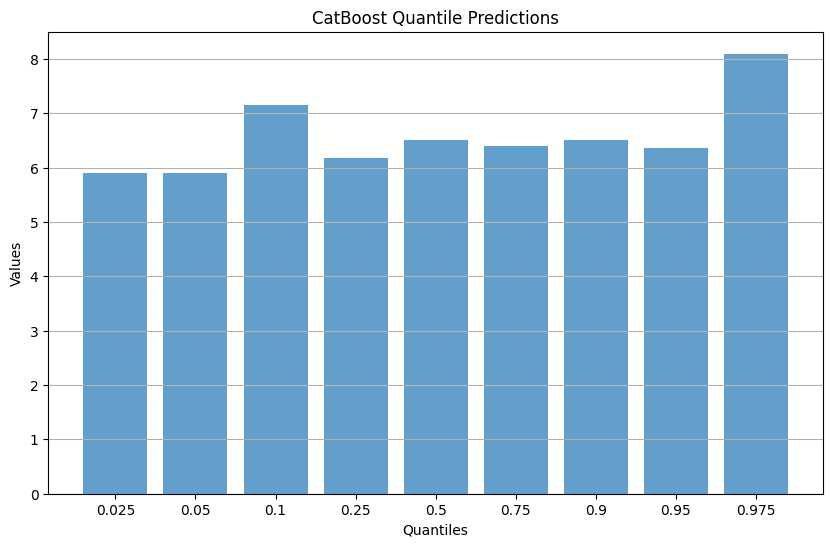

In [23]:
results_catboost_quantile[0]['pred_distribution']['quantiles']
# scatter plot of results_catboost_quantile[0]['pred_distribution']['quantiles'] which is a dict with keys '0.05', '0.25', '0.5', '0.75', '0.95'
import matplotlib.pyplot as plt
import numpy as np 
quantiles = results_catboost_quantile[0]['pred_distribution']['quantiles']
x = np.arange(len(quantiles))
plt.figure(figsize=(10, 6))
plt.bar(x, quantiles.values(), align='center', alpha=0.7)
plt.xticks(x, quantiles.keys())
plt.xlabel('Quantiles')
plt.ylabel('Values')
plt.title('CatBoost Quantile Predictions')
plt.grid(axis='y')
plt.show()


# Approach 4: Ratio-Based Methods

## Methodology

**Prediction Strategy**: Assume control arm outcome is a fixed proportion of the intervention arm outcome.

### Core Assumption:
**Control arm PFS = Ratio × Intervention arm PFS**

Where ratio ∈ {0.6, 0.7, 0.8, 0.9}

### Clinical Interpretation:
This method can be interpreted as assuming that **intervention arms are always better than control arms** by a consistent relative margin. The ratio represents the expected relative efficacy:

- **80% ratio**: Intervention is 25% better than control ((1/0.8 - 1) × 100%)
- **70% ratio**: Intervention is 43% better than control
- **90% ratio**: Intervention is 11% better than control

### Algorithm Steps:
1. **Intervention outcome**: Use actual intervention arm PFS
2. **Scaling**: Multiply by fixed ratio to get predicted control PFS
3. **ATE calculation**: ATE = Intervention PFS - Predicted Control PFS

### Evaluation of Multiple Ratios:
We test different ratios to understand sensitivity and identify optimal fixed assumptions.

**Strengths**: Simple, always predicts positive treatment effect, easy to implement
**Limitations**: Ignores trial heterogeneity, assumes constant relative efficacy, may not capture trials where intervention performs poorly

In [24]:
def ratio_method(ratio):
    results_ratio_7 = []

    for index, row in training_df.iterrows():
        rct_name = row[trial_id_col]
        is_arm_control = row[control_arm_col]
        
        if is_arm_control == 1:
            # Ground truth control outcome
            outcome_control = round(row[target_col], 2)
            
            # Get the treatment outcome of the RCT targeted
            trt_arm = training_df.loc[training_df[trial_id_col] == rct_name, :]
            trt_outcome = trt_arm.loc[trt_arm[control_arm_col] != 1, target_col]
            
            # Skip if treatment outcome is empty or NaN
            if trt_outcome.empty or pd.isna(trt_outcome.mean()):
                continue
                
            trt_outcome = round(trt_outcome.mean(), 2)
            
            # Predict control arm as 80% of treatment arm
            predicted_outcome = round(ratio * trt_outcome, 2)
            
            # Calculate ATEs
            real_ate = round(trt_outcome - outcome_control, 2)
            pred_ate = round(trt_outcome - predicted_outcome, 2)
            
            # Store results
            results_ratio_7.append({
                "real_ate": real_ate,
                "pred_ate": pred_ate,
                "outcome_control": outcome_control,
                "predicted_outcome": predicted_outcome,
                "rct_name": rct_name,
                "intervention": row["intervention"],
                "Arm": row["Arm"],
            })
            
            print(f"{rct_name} - arm: {row['Arm']} - {ratio} Ratio - intervention: {trt_outcome} - real_outcome: {outcome_control}, pred_outcome: {predicted_outcome}, real ATE: {real_ate} vs pred ATE: {pred_ate}")
    return results_ratio_7

results_ratio = ratio_method(0.8)
results_ratio_7 = ratio_method(0.7)
results_ratio_6 = ratio_method(0.6)
results_ratio_9 = ratio_method(0.9)

NCT01364012 - arm: Control - 0.8 Ratio - intervention: 9.2 - real_outcome: 6.5, pred_outcome: 7.36, real ATE: 2.7 vs pred ATE: 1.84
NCT01469000 - arm: Control - 0.8 Ratio - intervention: 15.8 - real_outcome: 10.9, pred_outcome: 12.64, real ATE: 4.9 vs pred ATE: 3.16
NCT03515837 - arm: Control - 0.8 Ratio - intervention: 5.6 - real_outcome: 5.5, pred_outcome: 4.48, real ATE: 0.1 vs pred ATE: 1.12
NCT04129502 - arm: Control - 0.8 Ratio - intervention: 9.6 - real_outcome: 9.6, pred_outcome: 7.68, real ATE: 0.0 vs pred ATE: 1.92
NCT04194203 - arm: Control - 0.8 Ratio - intervention: 9.5 - real_outcome: 7.1, pred_outcome: 7.6, real ATE: 2.4 vs pred ATE: 1.9
NCT04538664 - arm: Control - 0.8 Ratio - intervention: 11.4 - real_outcome: 6.7, pred_outcome: 9.12, real ATE: 4.7 vs pred ATE: 2.28
NCT04988295 - arm: Control - 0.8 Ratio - intervention: 7.3 - real_outcome: 4.2, pred_outcome: 5.84, real ATE: 3.1 vs pred ATE: 1.46
NCT02142738 - arm: Control - 0.8 Ratio - intervention: 7.7 - real_outcome:

# Ratio Estimation

Instead of hardcoding, we dynamically estimate ratio from training data

In [25]:
%autoreload 2

In [26]:
from utilities.ratio_estimation_utils import dynamic_ratio_method, ols_ratio_method

In [27]:
results_dynamic_simple = dynamic_ratio_method(training_df, trial_id_col, control_arm_col, target_col, method='simple')
results_dynamic_regression = dynamic_ratio_method(training_df, trial_id_col, control_arm_col, target_col, method='regression')
results_dynamic_cv = dynamic_ratio_method(training_df, trial_id_col, control_arm_col, target_col, method='cv')

NCT01364012 - arm: Control - Dynamic Ratio (0.724) - intervention: 9.2 - real_outcome: 6.5, pred_outcome: 6.66, real ATE: 2.7 vs pred ATE: 2.54
NCT01469000 - arm: Control - Dynamic Ratio (0.724) - intervention: 15.8 - real_outcome: 10.9, pred_outcome: 11.43, real ATE: 4.9 vs pred ATE: 4.37
NCT03515837 - arm: Control - Dynamic Ratio (0.714) - intervention: 5.6 - real_outcome: 5.5, pred_outcome: 4.0, real ATE: 0.1 vs pred ATE: 1.6
NCT04129502 - arm: Control - Dynamic Ratio (0.714) - intervention: 9.6 - real_outcome: 9.6, pred_outcome: 6.86, real ATE: 0.0 vs pred ATE: 2.74
NCT04194203 - arm: Control - Dynamic Ratio (0.714) - intervention: 9.5 - real_outcome: 7.1, pred_outcome: 6.79, real ATE: 2.4 vs pred ATE: 2.71
NCT04538664 - arm: Control - Dynamic Ratio (0.724) - intervention: 11.4 - real_outcome: 6.7, pred_outcome: 8.25, real ATE: 4.7 vs pred ATE: 3.15
NCT04988295 - arm: Control - Dynamic Ratio (0.724) - intervention: 7.3 - real_outcome: 4.2, pred_outcome: 5.28, real ATE: 3.1 vs pred 

In [28]:
# not using intercept. using intercept makes the results worse
results_ols_intercept = ols_ratio_method(training_df, trial_id_col, control_arm_col, target_col, use_intercept=False)

NCT01364012 - OLS_proportional - Ratio: 0.7239 (R²=0.963, n=21)
  Treatment: 9.2, Real Control: 6.5, Predicted Control: 6.66
  Real ATE: 2.7, Predicted ATE: 2.54
--------------------------------------------------------------------------------
NCT01469000 - OLS_proportional - Ratio: 0.7286 (R²=0.960, n=21)
  Treatment: 15.8, Real Control: 10.9, Predicted Control: 11.51
  Real ATE: 4.9, Predicted ATE: 4.29
--------------------------------------------------------------------------------
NCT03515837 - OLS_proportional - Ratio: 0.7184 (R²=0.966, n=21)
  Treatment: 5.6, Real Control: 5.5, Predicted Control: 4.02
  Real ATE: 0.1, Predicted ATE: 1.58
--------------------------------------------------------------------------------
NCT04129502 - OLS_proportional - Ratio: 0.7078 (R²=0.970, n=21)
  Treatment: 9.6, Real Control: 9.6, Predicted Control: 6.79
  Real ATE: 0.0, Predicted ATE: 2.81
--------------------------------------------------------------------------------
NCT04194203 - OLS_proport

In [29]:
pd.DataFrame(results_ols_intercept)['estimated_ratio'].median()

np.float64(0.72295)

In [30]:
pd.DataFrame(results_dynamic_simple)['estimated_ratio'].median(), pd.DataFrame(results_dynamic_regression)['estimated_ratio'].median(), pd.DataFrame(results_dynamic_cv)['estimated_ratio'].median()

(np.float64(0.714), np.float64(0.723), np.float64(0.7))

In [31]:
ratio_estimate_regression = pd.DataFrame(results_dynamic_regression)['estimated_ratio'].median()
ratio_estimate_ols_intercept = pd.DataFrame(results_ols_intercept)['estimated_ratio'].median()
results_ratio_estimate = ratio_method(ratio_estimate_regression)
results_ratio_estimate_ols = ratio_method(ratio_estimate_ols_intercept)


NCT01364012 - arm: Control - 0.723 Ratio - intervention: 9.2 - real_outcome: 6.5, pred_outcome: 6.65, real ATE: 2.7 vs pred ATE: 2.55
NCT01469000 - arm: Control - 0.723 Ratio - intervention: 15.8 - real_outcome: 10.9, pred_outcome: 11.42, real ATE: 4.9 vs pred ATE: 4.38
NCT03515837 - arm: Control - 0.723 Ratio - intervention: 5.6 - real_outcome: 5.5, pred_outcome: 4.05, real ATE: 0.1 vs pred ATE: 1.55
NCT04129502 - arm: Control - 0.723 Ratio - intervention: 9.6 - real_outcome: 9.6, pred_outcome: 6.94, real ATE: 0.0 vs pred ATE: 2.66
NCT04194203 - arm: Control - 0.723 Ratio - intervention: 9.5 - real_outcome: 7.1, pred_outcome: 6.87, real ATE: 2.4 vs pred ATE: 2.63
NCT04538664 - arm: Control - 0.723 Ratio - intervention: 11.4 - real_outcome: 6.7, pred_outcome: 8.24, real ATE: 4.7 vs pred ATE: 3.16
NCT04988295 - arm: Control - 0.723 Ratio - intervention: 7.3 - real_outcome: 4.2, pred_outcome: 5.28, real ATE: 3.1 vs pred ATE: 2.02
NCT02142738 - arm: Control - 0.723 Ratio - intervention: 7

# Approach 5: External Knowledge Method

## Methodology

**Prediction Strategy**: Use external literature/web sources to establish control arm benchmarks rather than learning from trial data.

### Data Source:
Based on published literature for lung cancer control arms, we use:
- **Fixed prediction**: 11.7 months PFS for all control arms
- **Literature basis**: Meta-analysis of chemotherapy outcomes in NSCLC

### Clinical Context:
Representative control arm outcomes from literature:
- Gefitinib Monotherapy: 11.1 months
- Chemotherapy (Pemetrexed/Carboplatin): 12.5 months
- Average benchmark: ~11.7 months

### Algorithm Steps:
1. **Fixed prediction**: Assign 11.7 months to all control arms
2. **ATE calculation**: Subtract fixed value from actual intervention outcomes
3. **No learning**: Does not adapt based on trial data

### Interpretation:
This represents the approach of using **external clinical knowledge** rather than data-driven learning. It simulates what clinicians might predict based on general domain expertise.

**Strengths**: Independent of data quality, incorporates domain expertise, simple
**Limitations**: May not reflect dataset-specific characteristics, assumes all trials have similar control arm populations

In [32]:
results_web = []
for index, row in training_df.iterrows():
    rct_name = row[trial_id_col]
    is_arm_control = row[control_arm_col]
    
    if is_arm_control == 1:
        # ground truth
        outcome_control = round(row[target_col], 2)
        
        # Get the trt outcome of the RCT targeted
        trt_arm = training_df.loc[training_df[trial_id_col] == rct_name, :]
        trt_outcome = trt_arm.loc[trt_arm[control_arm_col] != 1, target_col]
        trt_outcome = round(trt_outcome.mean(), 2)
        
        # Web info
        predicted_outcome = 11.7
    
        real_ate = round(trt_outcome - outcome_control, 2)
        pred_ate = round(trt_outcome - predicted_outcome, 2)
        results_web.append({
            "real_ate": real_ate,
            "pred_ate": pred_ate,
            "outcome_control": outcome_control,
            "predicted_outcome": predicted_outcome,
            "rct_name": rct_name,
            "intervention": row["intervention"],
            "Arm": row["Arm"],
        })
            
        print(f"{rct_name} - arm: {row['Arm']} - intervention: {trt_outcome} - real_outcome: {outcome_control}, pred_outcome: {predicted_outcome}, real ATE: {real_ate} vs pred ATE: {pred_ate}")

NCT01364012 - arm: Control - intervention: 9.2 - real_outcome: 6.5, pred_outcome: 11.7, real ATE: 2.7 vs pred ATE: -2.5
NCT01469000 - arm: Control - intervention: 15.8 - real_outcome: 10.9, pred_outcome: 11.7, real ATE: 4.9 vs pred ATE: 4.1
NCT03515837 - arm: Control - intervention: 5.6 - real_outcome: 5.5, pred_outcome: 11.7, real ATE: 0.1 vs pred ATE: -6.1
NCT04129502 - arm: Control - intervention: 9.6 - real_outcome: 9.6, pred_outcome: 11.7, real ATE: 0.0 vs pred ATE: -2.1
NCT04194203 - arm: Control - intervention: 9.5 - real_outcome: 7.1, pred_outcome: 11.7, real ATE: 2.4 vs pred ATE: -2.2
NCT04538664 - arm: Control - intervention: 11.4 - real_outcome: 6.7, pred_outcome: 11.7, real ATE: 4.7 vs pred ATE: -0.3
NCT04988295 - arm: Control - intervention: 7.3 - real_outcome: 4.2, pred_outcome: 11.7, real ATE: 3.1 vs pred ATE: -4.4
NCT02142738 - arm: Control - intervention: 7.7 - real_outcome: 5.5, pred_outcome: 11.7, real ATE: 2.2 vs pred ATE: -4.0
NCT02041533 - arm: Control - intervent

# Methods Comparison and Evaluation

## Performance Metrics Explanation

### Key Evaluation Criteria:

1. **ATE Direction Accuracy**: Most clinically important metric
   - Percentage of trials where predicted ATE has the correct sign (positive/negative)
   - Critical for trial go/no-go decisions

2. **R² Score (ATE)**: Goodness of fit for ATE predictions
   - Measures how well predicted ATEs correlate with actual ATEs
   - Higher values indicate better predictive accuracy

3. **Spearman Correlation (ATE)**: Rank-order correlation
   - Non-parametric measure robust to outliers
   - Important for relative ranking of trial attractiveness

4. **RMSE (ATE)**: Root Mean Squared Error for ATEs
   - Measures absolute prediction accuracy
   - Lower values indicate better precision

5. **RMSE (Outcome)**: RMSE for control arm predictions
   - Direct measure of control arm prediction accuracy
   - Important for sample size calculations

### Clinical Significance:
- **Direction accuracy** is most critical: Getting the sign wrong could lead to pursuing ineffective treatments
- **Magnitude accuracy** affects sample size and trial design
- **Ranking accuracy** helps prioritize among multiple potential trials

In [33]:
results_ml_df = pd.DataFrame(results_ml)
results_elastic_net_df = pd.DataFrame(results_elastic_net)
results_rf_df = pd.DataFrame(results_rf)
results_lgbm_df = pd.DataFrame(results_lgbm)
results_catboost_df = pd.DataFrame(results_catboost_quantile)
results_average_df = pd.DataFrame(results_average)
results_web_df = pd.DataFrame(results_web)
results_similar_df = pd.DataFrame(results_similarity)


results_ratio_df = pd.DataFrame(results_ratio)
results_ratio_7_df = pd.DataFrame(results_ratio_7)
results_ratio_6_df = pd.DataFrame(results_ratio_6)
results_ratio_9_df = pd.DataFrame(results_ratio_9)
results_ratio_estimate_df = pd.DataFrame(results_ratio_estimate)
results_ratio_estimate_ols_df = pd.DataFrame(results_ratio_estimate_ols)


In [34]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

In [35]:
results_ml_df

,real_ate,pred_ate,outcome_control,predicted_outcome,rct_name,intervention,Arm
0,2.70,1.62,6.5,7.58,NCT01364012,placebo + platinum doublet chemo (carboplatin ...,Control
1,4.90,5.31,10.9,10.49,NCT01469000,gefitinib,Control
2,0.10,-0.44,5.5,6.04,NCT03515837,placebo + pemtrexed + platinum-based chemo,Control
3,0.00,3.60,9.6,6.00,NCT04129502,platinum-based chemothrapy,Control
4,2.40,3.85,7.1,5.65,NCT04194203,placebo + bevacizumab + platinum-based chemo,Control
5,4.70,3.66,6.7,7.74,NCT04538664,placebo + platinum-based chemo,Control
6,3.10,0.37,4.2,6.93,NCT04988295,platinum-based chemothrapy (carboplatin + peme...,Control
7,2.20,2.51,5.5,5.19,NCT02142738,platinum + pemetrexed or gemcitabine or paclit...,Control
8,-1.70,-0.34,5.9,4.54,NCT02041533,platinum-based doublet chemotherapy,Control
9,2.40,2.15,5.2,5.45,NCT02657434,cisplatin or carboplatin + pemetrexed (PP),Control


In [36]:
fin_df = pd.DataFrame([
    calculate_perf(results_ml_df.dropna(), "ML Approach Lasso"),
    calculate_perf(results_rf_df.dropna(), "ML Approach RF"),
    calculate_perf(results_elastic_net_df.dropna(), "ML Approach ElasticNet"),
    calculate_perf(results_lgbm_df.dropna(), "ML Approach LightGBM"),
    calculate_perf(results_catboost_df.dropna(), "ML Approach CatBoost"),
    calculate_perf(results_average_df.dropna(), "Average approach"),
    calculate_perf(results_similar_df.dropna(), "Similarity approach"),
    calculate_perf(results_web_df.dropna(), "Web approach"),
    calculate_perf(results_ratio_df.dropna(), "80% Ratio Method"),
    calculate_perf(results_ratio_7_df.dropna(), "70% Ratio Method"),
    calculate_perf(results_ratio_estimate_df.dropna(), "Dynamic Ratio Method Regression"),
    calculate_perf(results_ratio_estimate_ols_df.dropna(), "Dynamic Ratio Method OLS Intercept"),

])
fin_df

,Approach,ATE direction true,r2_ate,spearman_ate,rmse_ate,r2_outcome,rmse_outcome
0,ML Approach Lasso,0.92,0.24,0.63,1.42,0.33,1.42
1,ML Approach RF,0.96,0.52,0.76,1.13,0.58,1.13
2,ML Approach ElasticNet,0.88,0.17,0.57,1.48,0.27,1.48
3,ML Approach LightGBM,0.92,0.49,0.82,1.16,0.55,1.16
4,ML Approach CatBoost,0.96,0.28,0.74,1.41,0.35,1.41
5,Average approach,0.88,-0.24,0.69,1.81,-0.09,1.81
6,Similarity approach,0.83,0.01,0.64,1.62,-0.39,2.04
7,Web approach,0.21,-11.04,0.71,5.66,-9.65,5.66
8,80% Ratio Method,0.88,0.30,0.71,1.36,0.39,1.36
9,70% Ratio Method,0.88,0.46,0.71,1.20,0.52,1.20


# Calculate additional metrics for Models with CI, distribution of predictions

CI width, CI coverage with actual CI(IoU), CI width

In [37]:
from utilities.utils import calculate_perf_enhanced_with_iou

In [38]:
pd.DataFrame([
calculate_perf_enhanced_with_iou(results_catboost_df.dropna(), "CatBoost Quantile",
                                  actual_ci_col='actual_outcome_ci',
                                  pred_ci_col='pred_ci_95'),
])



Calculating IoU using actual CI column: actual_outcome_ci and predicted CI column: pred_ci_95
IoU Statistics - Mean: 0.203, Median: 0.153
IoU Range: [0.0, 0.675], Std: 0.218
High IoU (>0.5): 17.4%, Very High IoU (>0.7): 0.0%


,Approach,r2_ate,r2_outcome,rmse_ate,rmse_outcome,spearman_ate,ATE direction true,abs_bias_ate,coverage_95_ate,avg_ci_width_ate,coverage_95_ate_from_samples,iou_outcome_scores,avg_iou_outcome,median_iou_outcome
0,CatBoost Quantile,0.28,0.35,1.41,1.41,0.74,0.96,0.976,0.565,1.507,0.565,"[0.522, 0.0, 0.156, 0.082, 0.098, 0.675, 0.0, ...",0.203,0.153


In [39]:
iou_outcomes_scores = pd.DataFrame([calculate_perf_enhanced_with_iou(results_catboost_df.dropna(), "CatBoost Quantile",
                                  actual_ci_col='actual_outcome_ci',
                                  pred_ci_col='pred_ci_95')])
iou_outcomes_scores['iou_outcome_scores'].tolist()[0]

Calculating IoU using actual CI column: actual_outcome_ci and predicted CI column: pred_ci_95
IoU Statistics - Mean: 0.203, Median: 0.153
IoU Range: [0.0, 0.675], Std: 0.218
High IoU (>0.5): 17.4%, Very High IoU (>0.7): 0.0%


[0.522,
 0.0,
 0.156,
 0.082,
 0.098,
 0.675,
 0.0,
 0.4,
 0.287,
 0.396,
 0.153,
 0.656,
 0.0,
 0.167,
 0.0,
 0.098,
 0.0,
 0.0,
 0.161,
 0.317,
 0.0,
 0.0,
 0.508]

In [40]:
iou_results_catboost_df = results_catboost_df.dropna().copy()
iou_results_catboost_df['iou_outcome_scores'] = iou_outcomes_scores['iou_outcome_scores'].tolist()[0]
iou_results_catboost_df[['real_ate', 'pred_ate', 'outcome_control', 'predicted_outcome',
                         'rct_name', 'intervention', 'Arm', 'actual_outcome_ci', 'pred_ci_95', 'iou_outcome_scores']]

,real_ate,pred_ate,outcome_control,predicted_outcome,rct_name,intervention,Arm,actual_outcome_ci,pred_ci_95,iou_outcome_scores
0,2.70,2.69,6.5,6.51,NCT01364012,placebo + platinum doublet chemo (carboplatin ...,Control,"[5.8, 7.1]","[5.9, 8.1]",0.522
1,4.90,8.24,10.9,7.56,NCT01469000,gefitinib,Control,"[9.7, 13.8]","[7.87, 7.24]",0.000
2,0.10,1.18,5.5,4.42,NCT03515837,placebo + pemtrexed + platinum-based chemo,Control,"[5.4, 5.6]","[4.4, 5.68]",0.156
3,0.00,2.58,9.6,7.02,NCT04129502,platinum-based chemothrapy,Control,"[7.2, 11.4]","[5.7, 7.67]",0.082
4,2.40,3.04,7.1,6.46,NCT04194203,placebo + bevacizumab + platinum-based chemo,Control,"[6.9, 9.5]","[6.12, 7.23]",0.098
5,4.70,3.60,6.7,7.80,NCT04538664,placebo + platinum-based chemo,Control,"[5.6, 7.3]","[5.4, 7.92]",0.675
6,3.10,1.69,4.2,5.61,NCT04988295,platinum-based chemothrapy (carboplatin + peme...,Control,"[4.0, 4.4]","[5.7, 6.52]",0.000
7,2.20,2.16,5.5,5.54,NCT02142738,platinum + pemetrexed or gemcitabine or paclit...,Control,"[4.2, 6.2]","[5.33, 6.13]",0.400
8,-1.70,-1.32,5.9,5.52,NCT02041533,platinum-based doublet chemotherapy,Control,"[5.4, 6.9]","[5.02, 5.94]",0.287
9,2.40,2.29,5.2,5.31,NCT02657434,cisplatin or carboplatin + pemetrexed (PP),Control,"[4.3, 5.6]","[4.86, 6.17]",0.396


## Visualization: Machine Learning Method

**Scatter plot for the conditional machine learning approach (Lasso regression).**

### Comparison with Simple Average:
- Compare this plot with the previous simple average plot
- Look for improved clustering around the diagonal
- Assess whether ML reduces systematic bias
- Identify if ML better handles extreme cases

### Expected Improvements:
- Better fit due to conditioning on intervention outcomes
- Reduced bias through feature-based adjustments
- More accurate predictions for trials with unique characteristics

The red diagonal line represents perfect predictions. Closer clustering to this line indicates better model performance.

In [41]:
results_catboost_df[['real_ate', 'pred_ate', 'ate_ci_95', 'rct_name', 'intervention', 'Arm', 'training_rmse', 'training_mae', 'training_set_std', 'training_pred_std']]

,real_ate,pred_ate,ate_ci_95,rct_name,intervention,Arm,training_rmse,training_mae,training_set_std,training_pred_std
0,2.70,2.69,"[1.1, 3.3]",NCT01364012,placebo + platinum doublet chemo (carboplatin ...,Control,0.036,0.009,1.770,1.759
1,4.90,8.24,"[7.93, 8.56]",NCT01469000,gefitinib,Control,0.049,0.016,1.476,1.447
2,0.10,1.18,"[-0.06, 1.2]",NCT03515837,placebo + pemtrexed + platinum-based chemo,Control,0.031,0.009,1.761,1.749
3,0.00,2.58,"[1.93, 3.9]",NCT04129502,platinum-based chemothrapy,Control,0.023,0.009,1.626,1.619
4,2.40,3.04,"[2.28, 3.8]",NCT04194203,placebo + bevacizumab + platinum-based chemo,Control,0.049,0.014,1.793,1.779
5,4.70,3.60,"[3.47, 6.0]",NCT04538664,placebo + platinum-based chemo,Control,0.087,0.024,1.768,1.738
6,3.10,1.69,"[0.79, 1.68]",NCT04988295,platinum-based chemothrapy (carboplatin + peme...,Control,0.065,0.015,1.712,1.693
7,2.20,2.16,"[1.57, 2.37]",NCT02142738,platinum + pemetrexed or gemcitabine or paclit...,Control,0.040,0.013,1.761,1.742
8,-1.70,-1.32,"[-1.71, -0.82]",NCT02041533,platinum-based doublet chemotherapy,Control,0.035,0.013,1.768,1.759
9,2.40,2.29,"[1.5, 2.81]",NCT02657434,cisplatin or carboplatin + pemetrexed (PP),Control,0.058,0.020,1.754,1.727


In [42]:
import plotly.graph_objects as go

fig = px.scatter(
    results_average_df,
    x='pred_ate',
    y='real_ate',
    color='Arm',  # Optional: color by group
    hover_name='rct_name',
    title='Real ATE vs Predicted ATE',
    labels={'real_ate': 'Real ATE', 'pred_ate': 'Predicted ATE'}
)

# Add y=x line
min_ate = min(results_average_df['real_ate'].min(), results_average_df['pred_ate'].min())
max_ate = max(results_average_df['real_ate'].max(), results_average_df['pred_ate'].max())
fig.add_trace(go.Scatter(
    x=[min_ate, max_ate],
    y=[min_ate, max_ate],
    mode='lines',
    line=dict(color='red', dash='dash'),
    name='Ideal (y = x)'
))

#fig.update_layout(width=700, height=500)
fig.show()

In [43]:

fig = px.scatter(
    results_ml_df,
    x='pred_ate',
    y='real_ate',
    color='Arm',  # Optional: color by group
    hover_name='rct_name',
    title='Real ATE vs Predicted ATE',
    labels={'real_ate': 'Real ATE', 'pred_ate': 'Predicted ATE'}
)

# Add y=x line
min_ate = min(results_ml_df['real_ate'].min(), results_ml_df['pred_ate'].min())
max_ate = max(results_ml_df['real_ate'].max(), results_ml_df['pred_ate'].max())
fig.add_trace(go.Scatter(
    x=[min_ate, max_ate],
    y=[min_ate, max_ate],
    mode='lines',
    line=dict(color='red', dash='dash'),
    name='Ideal (y = x)'
))

#fig.update_layout(width=700, height=500)
fig.show()

In [44]:

fig = px.scatter(
    results_catboost_df,
    x='pred_ate',
    y='real_ate',
    color='Arm',  # Optional: color by group
    hover_name='rct_name',
    title='Real ATE vs Predicted ATE',
    labels={'real_ate': 'Real ATE', 'pred_ate': 'Predicted ATE'}
)

# Add y=x line
min_ate = min(results_catboost_df['real_ate'].min(), results_catboost_df['pred_ate'].min())
max_ate = max(results_catboost_df['real_ate'].max(), results_catboost_df['pred_ate'].max())
fig.add_trace(go.Scatter(
    x=[min_ate, max_ate],
    y=[min_ate, max_ate],
    mode='lines',
    line=dict(color='red', dash='dash'),
    name='Ideal (y = x)'
))

#fig.update_layout(width=700, height=500)
fig.show()